## Лабораторная работа №4 
###  По предмету "методы, средства и технологии мультимедиа"
#### Выполнил: Пивницкий Д.С. 
#### Группа: М8о-406Б-19

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode


In [11]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = { # аугментации и преобразование в тензоры
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './pizza_not_pizza'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']} # загрузка датасета
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4) 
              for x in ['train', 'val']} # создание загрузчиков
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes # определение имен классов

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # выбираем, что использовать: видеокарту или cpu
                                                                        # по умолчанию стараемся использовать gpu, потому что он быстрее
    


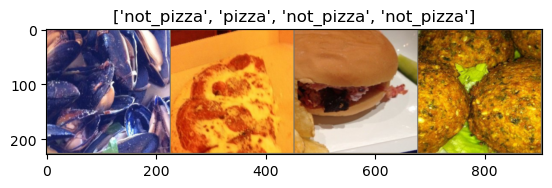

In [14]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # замена размерностей, чтобы формат подходил для imshow 
    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    #запоминаем время для финального подсчета времени

    best_model_wts = copy.deepcopy(model.state_dict()) # инициализация переменной текущим состоянием модели
                                                       # переменная нужна для хранения состояния модели, которое дает наибольшую точность классификации
        
    
    best_acc = 0.0 # точность, которую дает состояние, записанное в переменной выше. инициализируется нулем

    for epoch in range(num_epochs): # проход по эпохам
        print(f'Epoch {epoch}/{num_epochs - 1}') 
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0 # инициализация переменных, в которые будут записываться суммарные значения функции потерь
            running_corrects = 0 # и количество верных предсказаний. Нужны для рассчета метрик, чтобы считать не среднее средних за каждый батч, а сразу за всю эпоху

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device) #отправка данных на работающее устройство (cuda device / cpu)
                labels = labels.to(device) #отправка данных на работающее устройство (cuda device / cpu)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # результат применения модели к входным данным
                    _, preds = torch.max(outputs, 1) # outputs - это только значения score, тут же определяется, какой класс более вероятен
                    
                    loss = criterion(outputs, labels) # рассчет значения функции потерь

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward() # применение алгоритма обратного распространения ошибки
                        optimizer.step() # оптимизация параметров модели

                # statistics
                running_loss += loss.item() * inputs.size(0)
                # loss.item() дает средние потери по батчу, running loss это сумма потерь, так что loss.item умножвется на размер батча (inputs.size(0))
                running_corrects += torch.sum(preds == labels.data)
                # пополнение суммы корректных предсказаний
            if phase == 'train':
                scheduler.step() # shceduer нужен для изменения lr в ходе обучения

            epoch_loss = running_loss / dataset_sizes[phase] # рассчет среднего значений функции потерь по всему датасету
            epoch_acc = running_corrects.double() / dataset_sizes[phase] # рассчет части верных предсказаний от общего размера датасета

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc: # выбираются веса, которые дают лучший результат на валидации
                                                        # а не просто веса последнего шага
                best_acc = epoch_acc #запоминаем лучшую точность
                best_model_wts = copy.deepcopy(model.state_dict()) # запоминаем веса (состояние модели), которые ее дают

        print()

    time_elapsed = time.time() - since # сколько времени прошло с начала обучения
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts) #загрузка состояния модели, которое дает наибольшую точность на валидации
    return model


In [15]:
def visualize_model(model, num_images=6): # показывает результаты (предсказанный класс и картинку)
    was_training = model.training # сохранение прошлого режима обучения
    model.eval() # переключает модель в режим не обучения 
    images_so_far = 0 # счетчик 
    fig = plt.figure() 

    with torch.no_grad(): # отключает рассчет градиентов, так как нам тут не нужно обратное распространение
        for i, (inputs, labels) in enumerate(dataloaders['val']): # enumerate добавляет к каждому элементу его номер
            inputs = inputs.to(device) #отправка данных на работающее устройство (cuda device / cpu)
            labels = labels.to(device) #отправка данных на работающее устройство (cuda device / cpu)

            outputs = model(inputs) # результат применения модели к входным данным
            _, preds = torch.max(outputs, 1)# определяется, какой класс более вероятен

            for j in range(inputs.size()[0]): # идем по батчу
                images_so_far += 1 # инкрементация счетчика
                ax = plt.subplot(num_images//2, 2, images_so_far) # форматирование чертежа
                ax.axis('off') # форматирование чертежа
                ax.set_title(f'predicted: {class_names[preds[j]]}') # вывод предсказания
                imshow(inputs.cpu().data[j]) # вывод изображения

                if images_so_far == num_images: # остановка, если показали столько примеров, сколько надо
                    model.train(mode=was_training) # возврат модели к прошлому режиму обучения
                    return
        model.train(mode=was_training) # перевод модели в режим обучения


In [16]:
model_ft = models.resnet18(pretrained=True) # создание предобученной модели resnet18 
num_ftrs = model_ft.fc.in_features # определяется, сверточная часть этой модели выдает выходных фич
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)). Да, было бы очень неплохо, если бы это было генерализировано с самого начала
model_ft.fc = nn.Linear(num_ftrs, 6) # добавляется полносвязный слой, обращающий фичи со сверточной части в 6 выходных параметров - вероятности i-го класса

model_ft = model_ft.to(device) # копирование модели на активное устройство

criterion = nn.CrossEntropyLoss() # выбор критерия - как считается функция потерь

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9) # выбор оптимизатора - какой метод используется для изменения параметров

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1) # выбор того, как изменяется lr с течением эпох


In [18]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=4)
# собственно обучение модели

Epoch 0/3
----------
train Loss: 0.4974 Acc: 0.8040
val Loss: 0.2386 Acc: 0.8943

Epoch 1/3
----------
train Loss: 0.5401 Acc: 0.7965
val Loss: 0.4615 Acc: 0.7967

Epoch 2/3
----------
train Loss: 0.4751 Acc: 0.8115
val Loss: 0.2432 Acc: 0.9241

Epoch 3/3
----------
train Loss: 0.3453 Acc: 0.8585
val Loss: 0.2062 Acc: 0.9214

Training complete in 26m 10s
Best val Acc: 0.924119


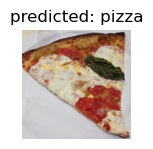

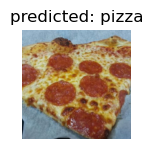

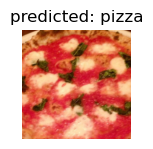

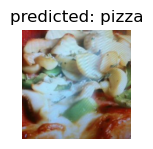

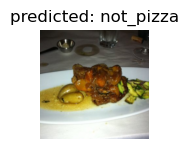

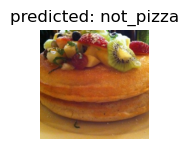

In [20]:
visualize_model(model_ft)

In [21]:
model_conv = torchvision.models.resnet18(pretrained=True) # создание предобученной модели resnet18 
for param in model_conv.parameters(): # в этот раз отключаем обучение всех предобученных параметров
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features # сколько фич выдается на полносвязный слой
model_conv.fc = nn.Linear(num_ftrs, 6) # задаем свой полносвязный слой на наши классы

model_conv = model_conv.to(device) # переносим модель на устройство

criterion = nn.CrossEntropyLoss() # выбираем функцию потерь

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9) # выбираем метод изменения параметров

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1) # выбираем метод изменения скрорости обучения


In [22]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=4)
# обучаем модель

Epoch 0/3
----------
train Loss: 0.6027 Acc: 0.7151
val Loss: 0.2222 Acc: 0.9051

Epoch 1/3
----------
train Loss: 0.5094 Acc: 0.7815
val Loss: 0.2118 Acc: 0.9051

Epoch 2/3
----------
train Loss: 0.5192 Acc: 0.8065
val Loss: 0.4618 Acc: 0.8428

Epoch 3/3
----------
train Loss: 0.5327 Acc: 0.7783
val Loss: 0.3133 Acc: 0.8753

Training complete in 13m 13s
Best val Acc: 0.905149


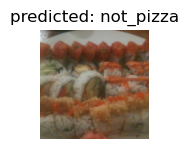

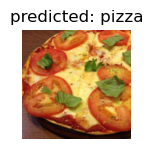

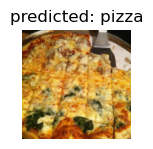

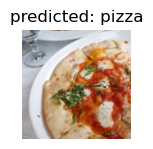

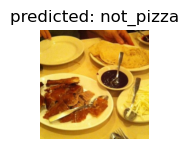

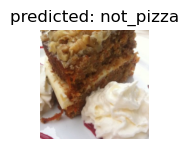

In [24]:
visualize_model(model_conv)

plt.ioff()
plt.show()

### Вывод

В ходе выполнения работы я узнал как просто создать датасет из папок, и как полезен running loss. Из примеров видно, что при отключении обучения параметров предобученной модели увеличивается скорость обучения с сохранением точности предсказания.